In [382]:
import requests
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager


In [220]:
def GET_URL(brand, location):
    try:
        brand = brand.lower()
        location = location.lower()

        locations = {
            'delhi ncr': 1,
            'new delhi': 2,
            'mumbai': 2378,
            'bangalore': 5709,
            'hyderabad': 3686,
            'ahmedabad': 1692,
            'gurgaon': 5,
            'chennai': 5732,
            'pune': 2423,
            'noida': 134,
            'ghaziabad': 132,
            'lucknow': 290,
            'jaipur': 2130,
            'kolkata': 777,
            'kochi': 6356,
            'indore': 2920
        }
        
        if location in locations:
            location_id = locations[location]
        else:
            raise ValueError(f"Location '{location}' is not supported")
        
        url = f'https://www.cars24.com/buy-used-car?f=make%3A%3D%3A{brand}&storeCityId={location_id}'
        return url

    except Exception as e:
        print(f"Can't return the url for {brand} in {location}: {e}")
        return None

In [ ]:
def DATA_EXTRACT(brand, location):
    cars = []
    
    try:
        url = GET_URL(brand, location)
        response = requests.get(url)

        if response.status_code == 200:
            driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
            driver.get(url)

            last_height = driver.execute_script("return document.body.scrollHeight")
            while True:
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(1)
                
                new_height = driver.execute_script("return document.body.scrollHeight")
                if new_height == last_height:
                    break
                last_height = new_height

            soup = BeautifulSoup(driver.page_source, 'html.parser')

            try:
                results = soup.find_all('div', {'class':'_2YB7p'})

                for c in results:
                    car = {}
                    
                    car['name'] = ' '.join(c.find('h3').get_text().split(' ')[1:])
                    car['kilometers_driven'] = c.find_all('li')[0].get_text()
                    car['year_of_manufacture'] = c.find('h3').get_text().split(' ')[0]
                    car['fuel_type'] = c.find_all('li')[2].get_text()
                    car['transmission'] = c.find_all('li')[4].get_text()
                    car['price'] = c.find('strong', {'class':'_3RL-I'}).get_text()

                    cars.append(car)

            except Exception as e:
                print(f'Error in data extraction: {e}')
            
            driver.quit()
        
        else:
            print(response.status_code)
            return None

        return cars
    
    except Exception as e:
        print(f"An error occurred for {brand} in {location}: {e}")
        return None

In [316]:
def DATA_CLEAN(df):
    try:
        df['kilometers_driven'] = df['kilometers_driven'].replace(r',| km', '', regex=True).astype(int)
        df['price'] = df['price'].replace(r'₹| Lakh', '', regex=True).astype('float64')

        df['name'] = df['name'].astype(str)
        df['transmission'] = df['transmission'].astype(str)
        df['fuel_type'] = df['fuel_type'].astype(str)

        df['year_of_manufacture'] = df['year_of_manufacture'].astype(int)

        df = df.dropna()

        return df

    except Exception as e:
        print(f"Error in data cleaning: {e}")

In [341]:
data = DATA_EXTRACT('Audi', 'Mumbai')

df = pd.DataFrame(data)
df.head()

""


In [348]:
loc = ['delhi ncr', 'new delhi', 'mumbai', 'bangalore', 'hyderabad', 'ahmedabad', 'gurgaon', 'chennai', 'pune', 'noida', 'ghaziabad', 'lucknow', 'jaipur', 'kolkata', 'kochi', 'indore']

for l in loc:
    data = DATA_EXTRACT('Audi', l)

    if len(data) != 0:
        print(f"{len(data)} found: {l}")
        df = pd.DataFrame(data)
        break
    else:
        print(f"{l} skip")

delhi ncr skip
new delhi skip
mumbai skip
bangalore skip
hyderabad skip
ahmedabad skip
gurgaon skip
chennai skip
pune skip
noida skip
ghaziabad skip
lucknow skip
jaipur skip
kolkata skip
kochi skip
indore skip


In [379]:
data = DATA_EXTRACT('Honda', 'noida')

df = pd.DataFrame(data)
df.head()

,name,kilometers_driven,year_of_manufacture,fuel_type,transmission,price
0,Honda Jazz 1.2L I-VTEC X,"46,924 km",2012,Petrol,Manual,₹2.52 Lakh
1,Honda City 1.5L I-VTEC V MT,"97,044 km",2015,Petrol,Manual,₹5.45 Lakh
2,Honda City 1.5L I-VTEC SV,"1,02,712 km",2017,Petrol,Manual,₹6.48 Lakh
3,Honda WR-V 1.2L I-VTEC VX MT,"40,799 km",2019,Petrol,Manual,₹7.34 Lakh
4,Honda City 1.5L I-VTEC V MT,"89,726 km",2015,Petrol,Manual,₹5.50 Lakh


In [355]:
df_ = DATA_CLEAN(df)
df_.head()

,name,kilometers_driven,year_of_manufacture,fuel_type,transmission,price
0,Honda Jazz 1.2L I-VTEC X,46924,2012,Petrol,Manual,2.52
1,Honda City 1.5L I-VTEC V MT,97044,2015,Petrol,Manual,5.45
2,Honda City 1.5L I-VTEC SV,102712,2017,Petrol,Manual,6.48
3,Honda WR-V 1.2L I-VTEC VX MT,40799,2019,Petrol,Manual,7.34
4,Honda City 1.5L I-VTEC V MT,89726,2015,Petrol,Manual,5.50


In [356]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 125 non-null    object 
 1   kilometers_driven    125 non-null    int32  
 2   year_of_manufacture  125 non-null    int32  
 3   fuel_type            125 non-null    object 
 4   transmission         125 non-null    object 
 5   price                125 non-null    float64
dtypes: float64(1), int32(2), object(3)
memory usage: 5.0+ KB


In [378]:
print(f'number of unique cars listed: {df_['name'].nunique()}', '\n')
print(f'max kms driven: {df_['kilometers_driven'].max()}')
print(f'min kms driven: {df_['kilometers_driven'].min()}', '\n')
print(f'oldest car listed: {df_['year_of_manufacture'].min()}')
print(f'newest car listed: {df_['year_of_manufacture'].max()}', '\n')
print(f'max price: {df_['price'].max()}')
print(f'min price: {df_['price'].min()}', '\n')
print(f'fuel types: {df_['fuel_type'].unique()}')
print(f'transmission types: {df_['transmission'].unique()}')

number of unique cars listed: 40 

max kms driven: 124116
min kms driven: 5404 

oldest car listed: 2011
newest car listed: 2023 

max price: 12.51
min price: 1.88 

fuel types: ['Petrol' 'CNG' 'Diesel']
transmission types: ['Manual' 'Automatic']


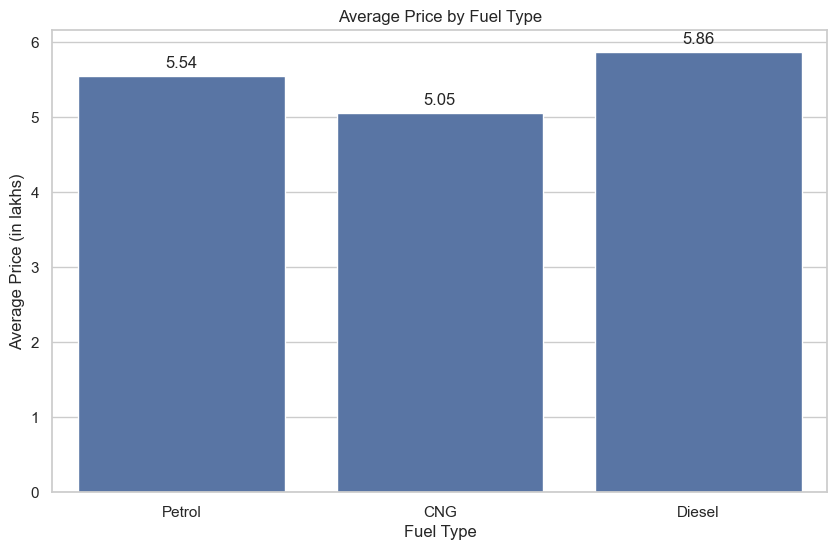

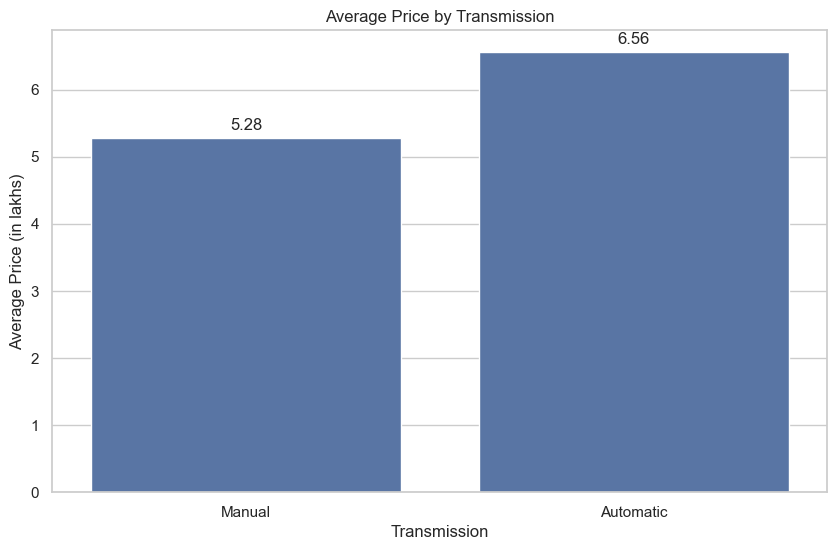

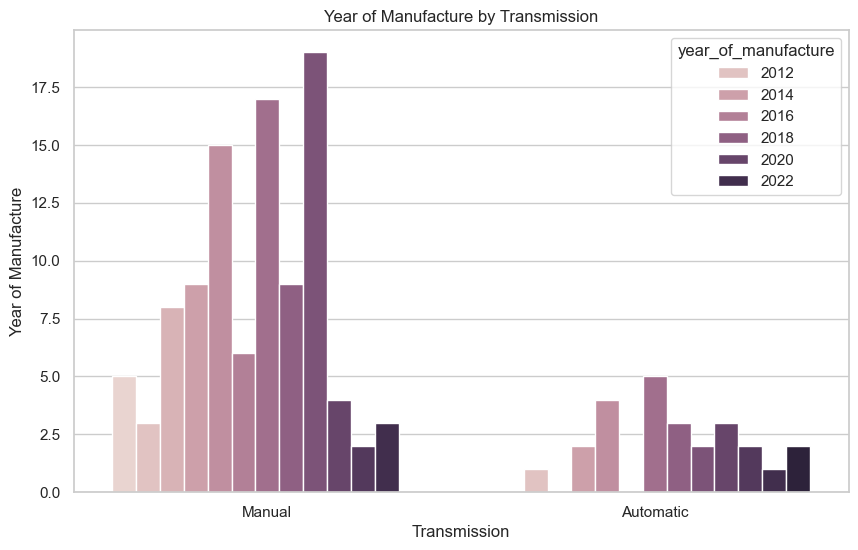

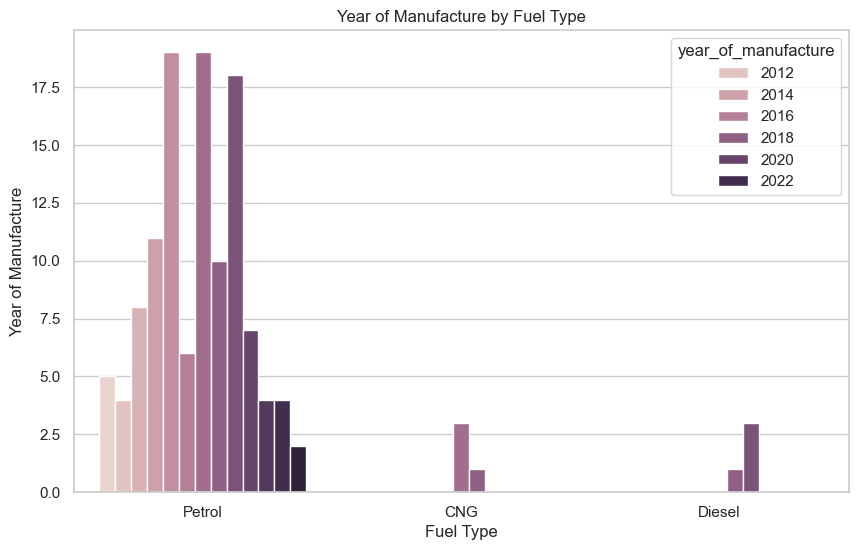

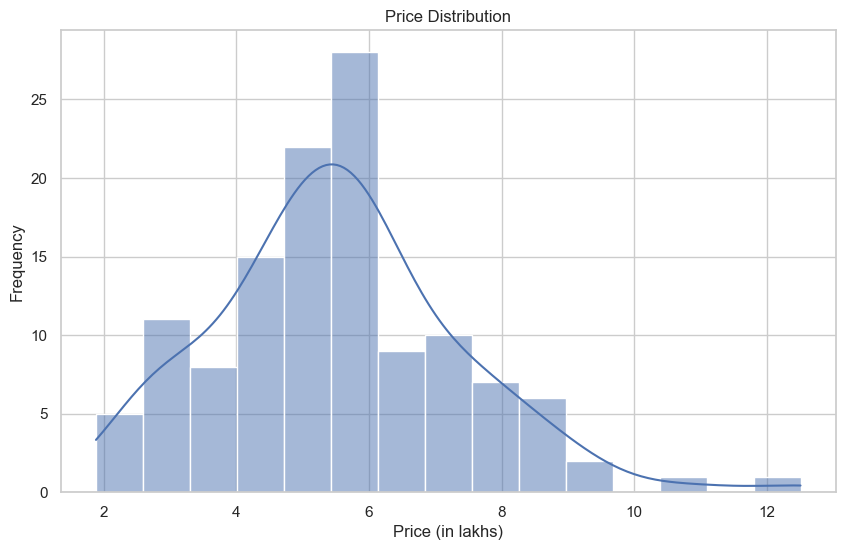

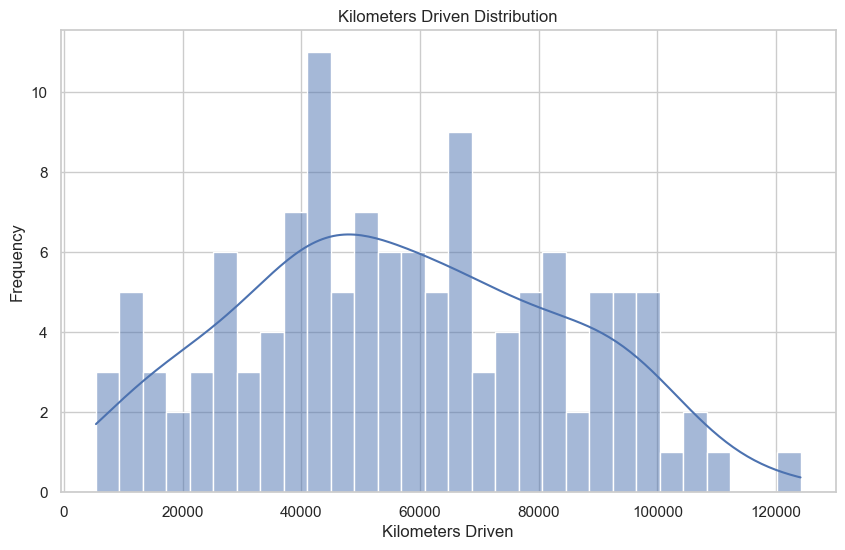

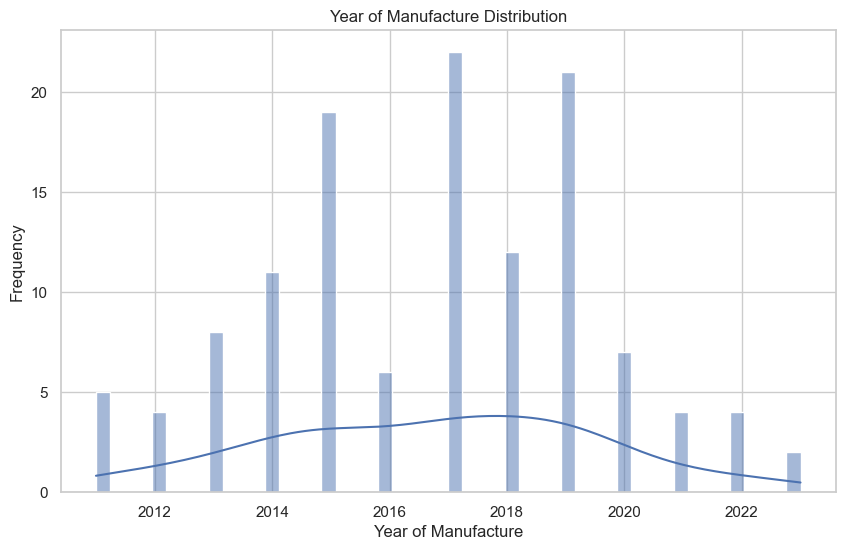

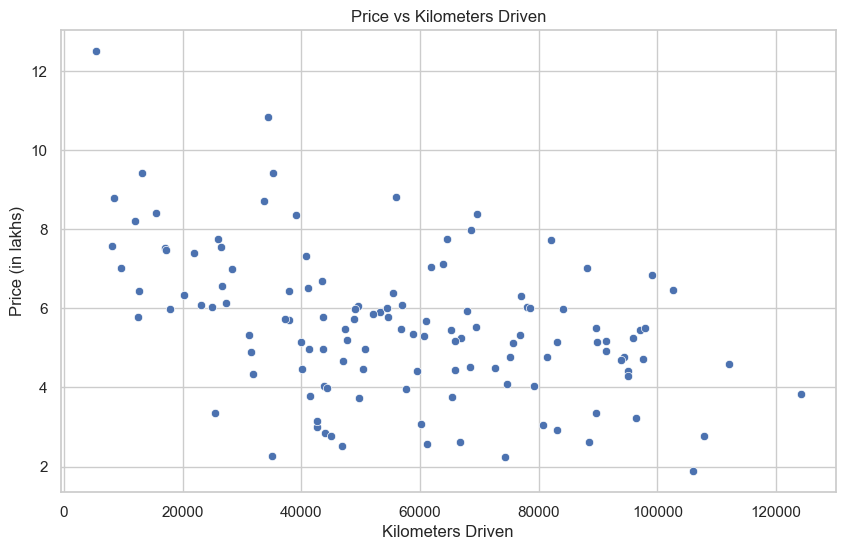

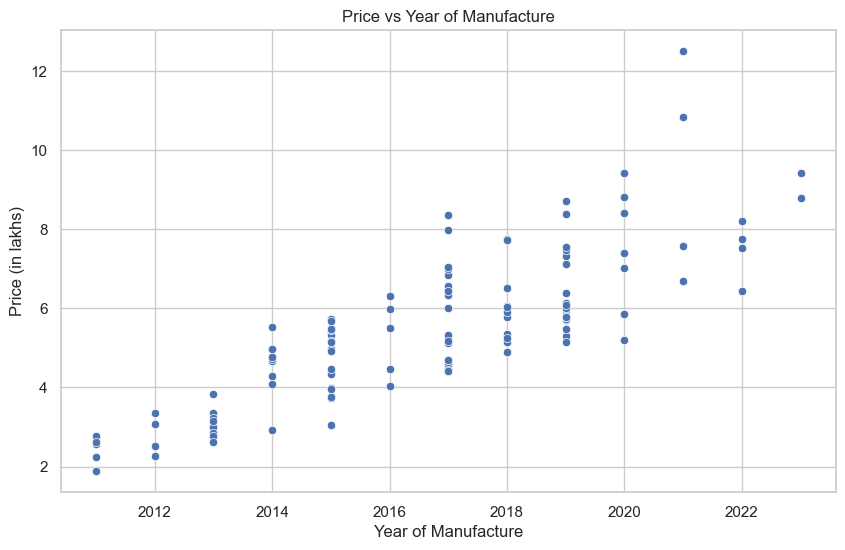

In [454]:
sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='fuel_type', y='price', data=df_, errorbar=None)
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9), textcoords = 'offset points')
plt.title('Average Price by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Average Price (in lakhs)')
plt.show()

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='transmission', y='price', data=df_, errorbar=None)
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9), textcoords = 'offset points')
plt.title('Average Price by Transmission')
plt.xlabel('Transmission')
plt.ylabel('Average Price (in lakhs)')
plt.show()



plt.figure(figsize=(10, 6))
count_plot = sns.countplot(x='transmission', data=df_, hue='year_of_manufacture')
plt.title('Year of Manufacture by Transmission')
plt.xlabel('Transmission')
plt.ylabel('Year of Manufacture')
plt.show()

plt.figure(figsize=(10, 6))
count_plot = sns.countplot(x='fuel_type', data=df_, hue='year_of_manufacture')
plt.title('Year of Manufacture by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Year of Manufacture')
plt.show()



plt.figure(figsize=(10, 6))
sns.histplot(df_, x='price', bins=15, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price (in lakhs)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_, x='kilometers_driven', bins=30, kde=True)
plt.title('Kilometers Driven Distribution')
plt.xlabel('Kilometers Driven')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_, x='year_of_manufacture', bins=50, kde=True)
plt.title('Year of Manufacture Distribution')
plt.xlabel('Year of Manufacture')
plt.ylabel('Frequency')
plt.show()



plt.figure(figsize=(10, 6))
sns.scatterplot(x='kilometers_driven', y='price', data=df_)
plt.title('Price vs Kilometers Driven')
plt.xlabel('Kilometers Driven')
plt.ylabel('Price (in lakhs)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='year_of_manufacture', y='price', data=df_)
plt.title('Price vs Year of Manufacture')
plt.xlabel('Year of Manufacture')
plt.ylabel('Price (in lakhs)')
plt.show()